# Study beam head rotation, motor angles vs simulation Euler angles 


In [1]:
%load_ext autoreload
%autoreload 


In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=16

# Build a telescope

In [3]:
# Second CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[0.004, 0.04, 0.15])


0

# Beam head rotation

In [4]:
# function to build a config from motor angles (u, b)
from scipy.spatial.transform import Rotation as transform_rotation
def config_from_angles(beam_conf, u, b):
    theta = u
    phi = b
    rot = transform_rotation.from_rotvec([0, phi, theta], degrees=True)
    eulers = rot.as_euler('zyx', degrees=True)
    beam_conf['z_euler'] = eulers[0]
    beam_conf['y_euler'] = eulers[1]
    beam_conf['x_euler'] = eulers[2]
    return beam_conf


Direct path is number 28
  central impact point is (-0.000019, -0.000020)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 778.5518


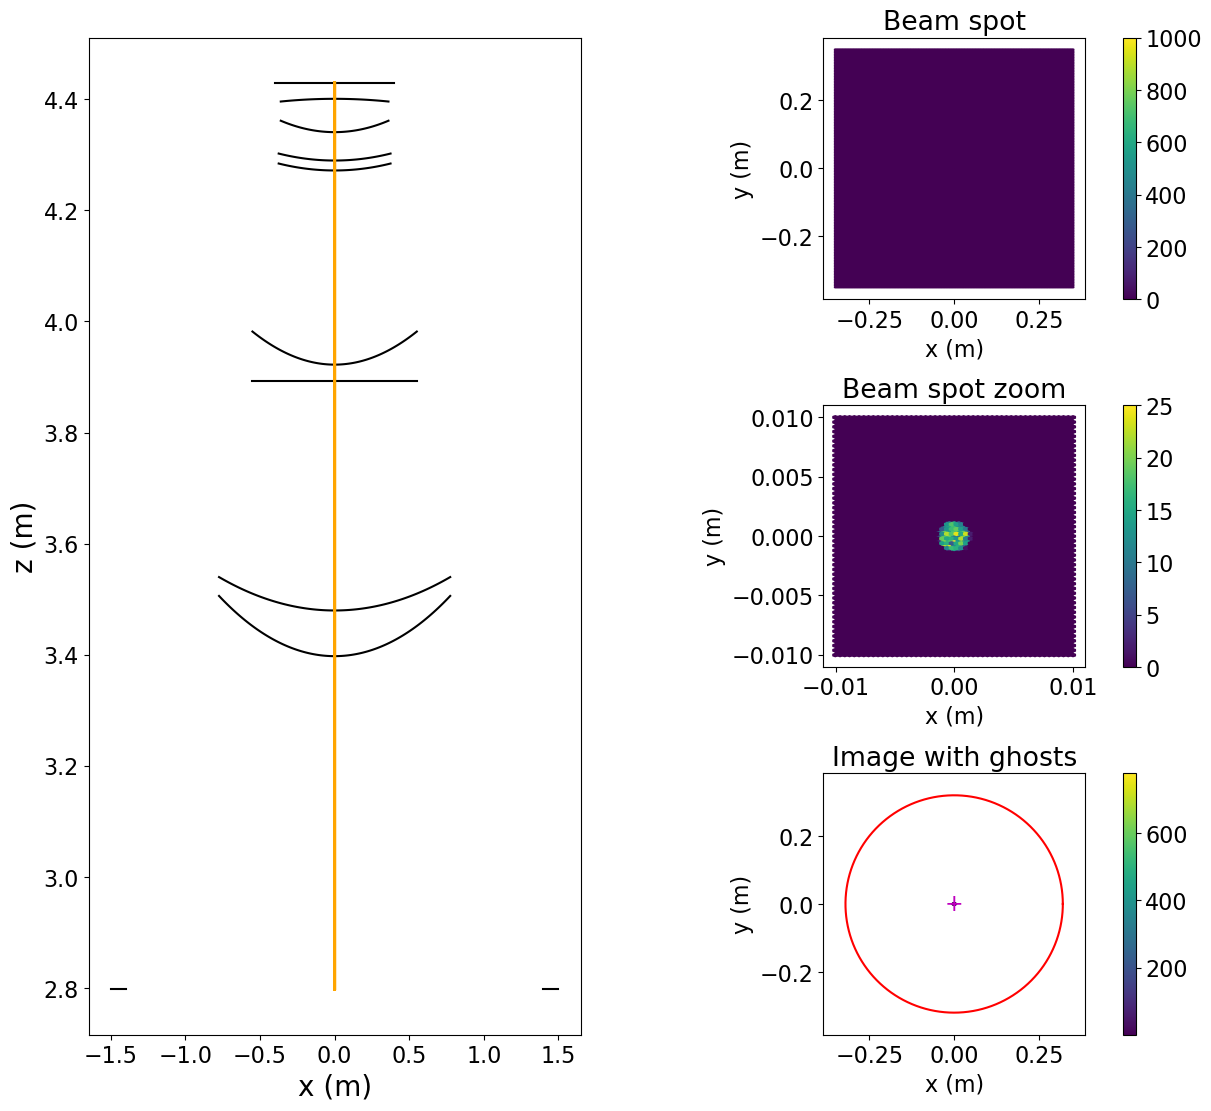

0

In [5]:
# check that the beam correctly points toward center
center = copy.deepcopy(BEAM_CONFIG_0)
test_beam = config_from_angles(center, u=0, b=0)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 28
  central impact point is (0.094787, -0.000026)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 626.9847


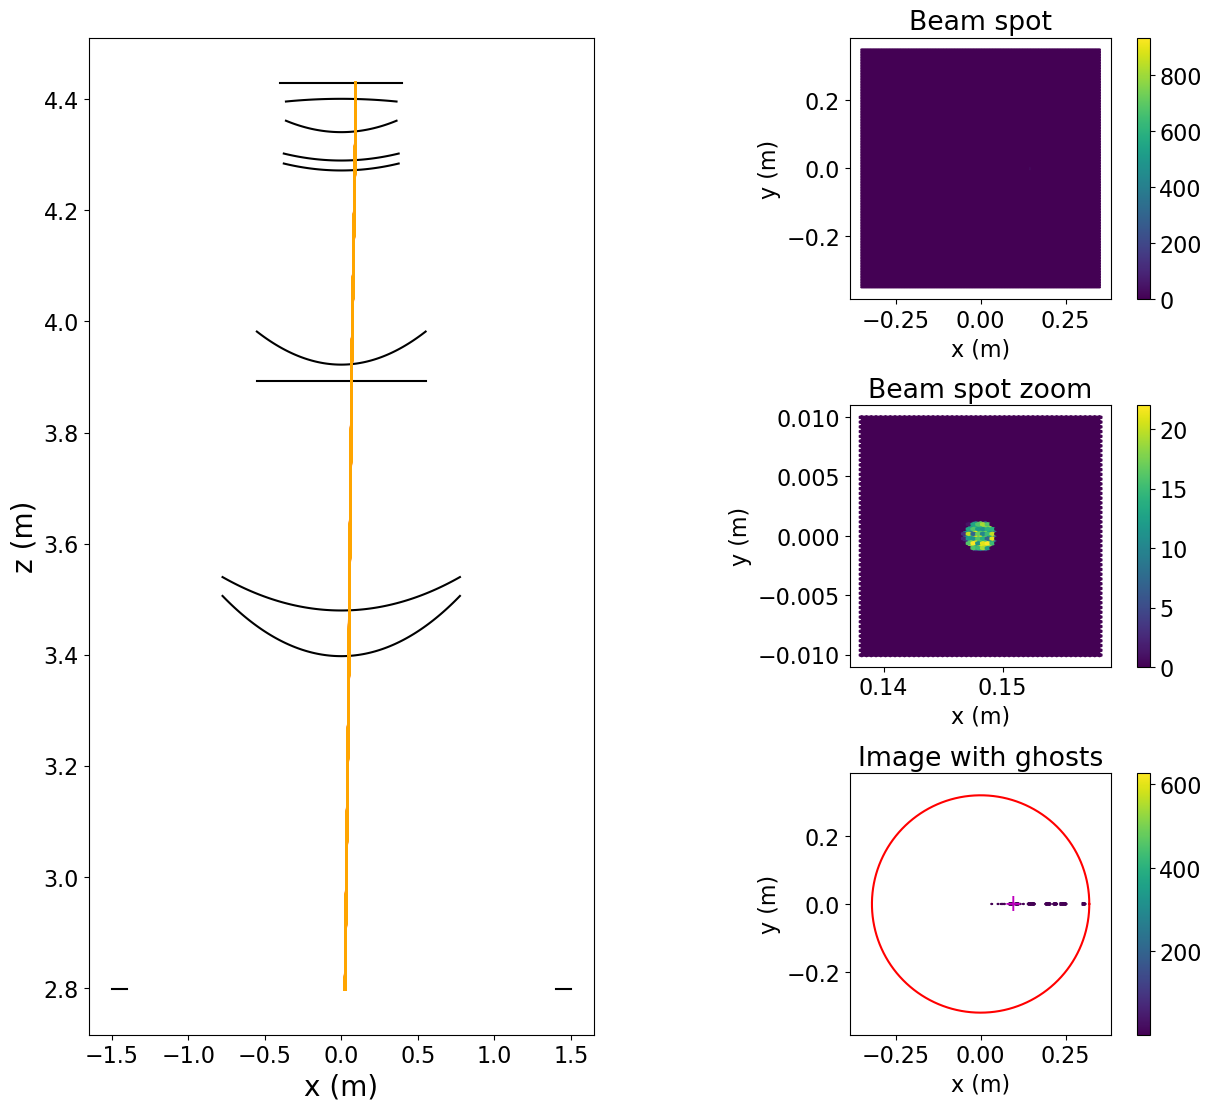

0

In [6]:
# check that the u=0 and b>0 moves beam on +x (cf. Andy)
center = copy.deepcopy(BEAM_CONFIG_0)
test_beam = config_from_angles(center, u=0, b=2.5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 22
  central impact point is (0.120674, 0.121149)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 748.9852


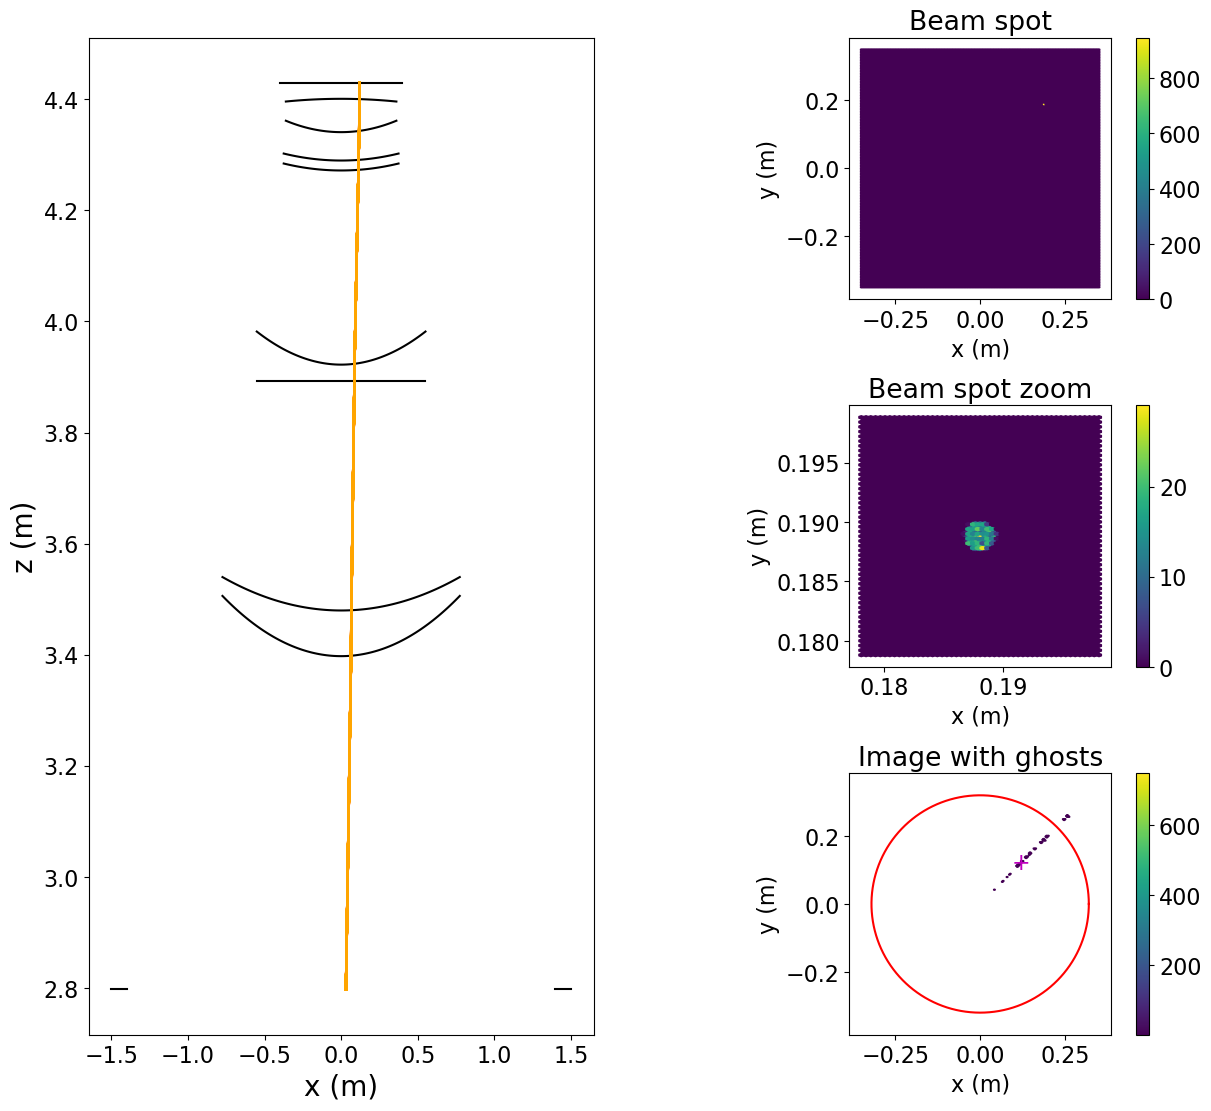

0

In [7]:
# check that with u=large and b=5 the beams rotates around the clock
center = copy.deepcopy(BEAM_CONFIG_0)
test_beam = config_from_angles(center, u=90, b=5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 27
  central impact point is (-0.000081, 0.120717)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 662.2385


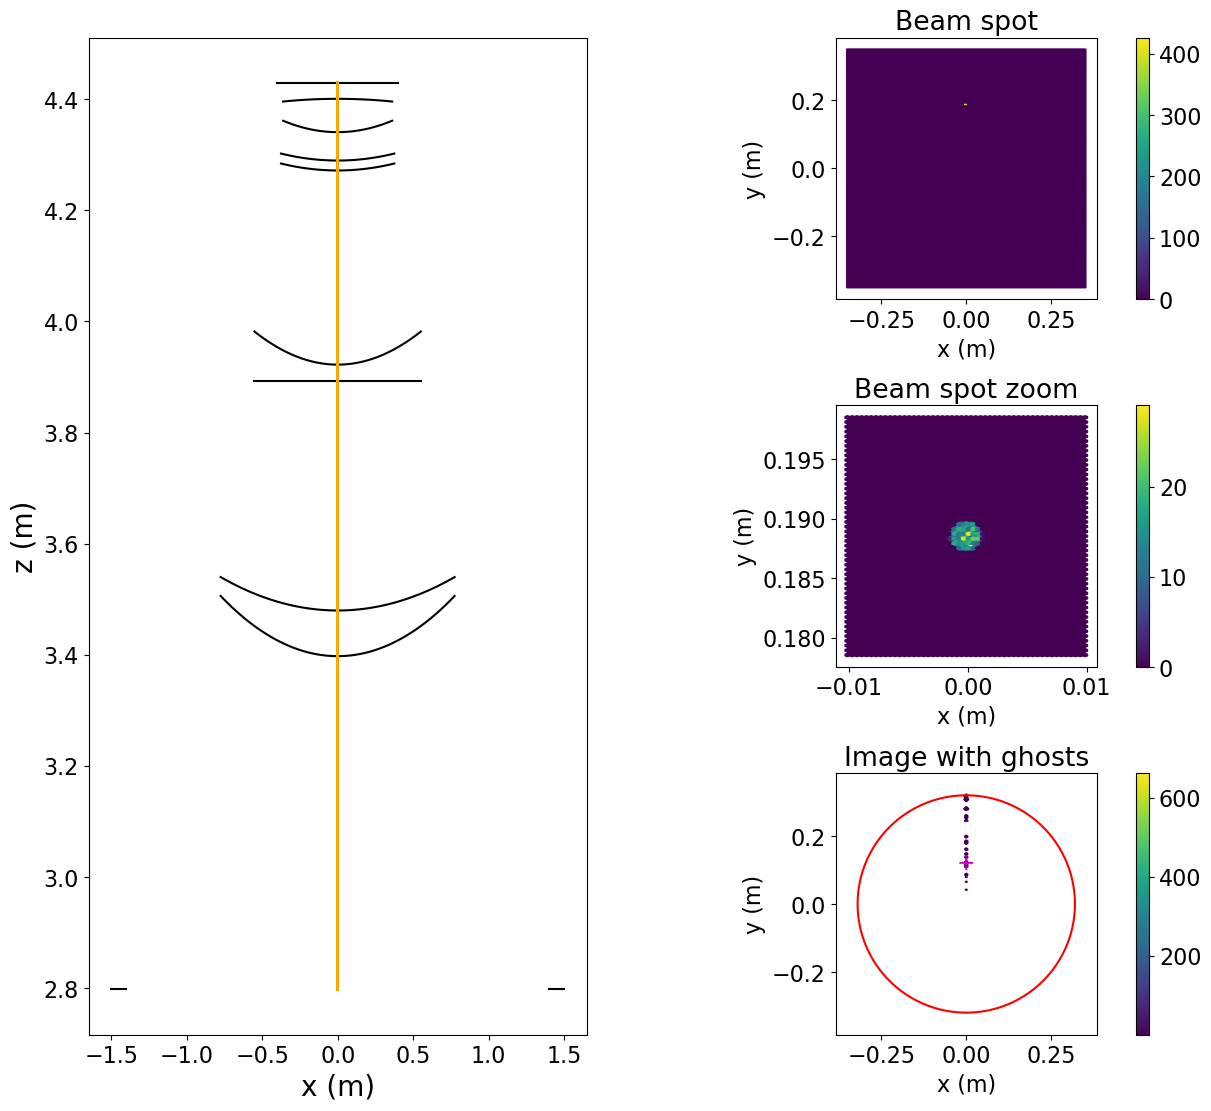

0

In [8]:
# check that with u=large and b=5 the beams rotates around the clock
center = copy.deepcopy(BEAM_CONFIG_0)
test_beam = config_from_angles(center, u=180, b=5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

Direct path is number 28
  central impact point is (0.000023, 0.040198)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 284.5815


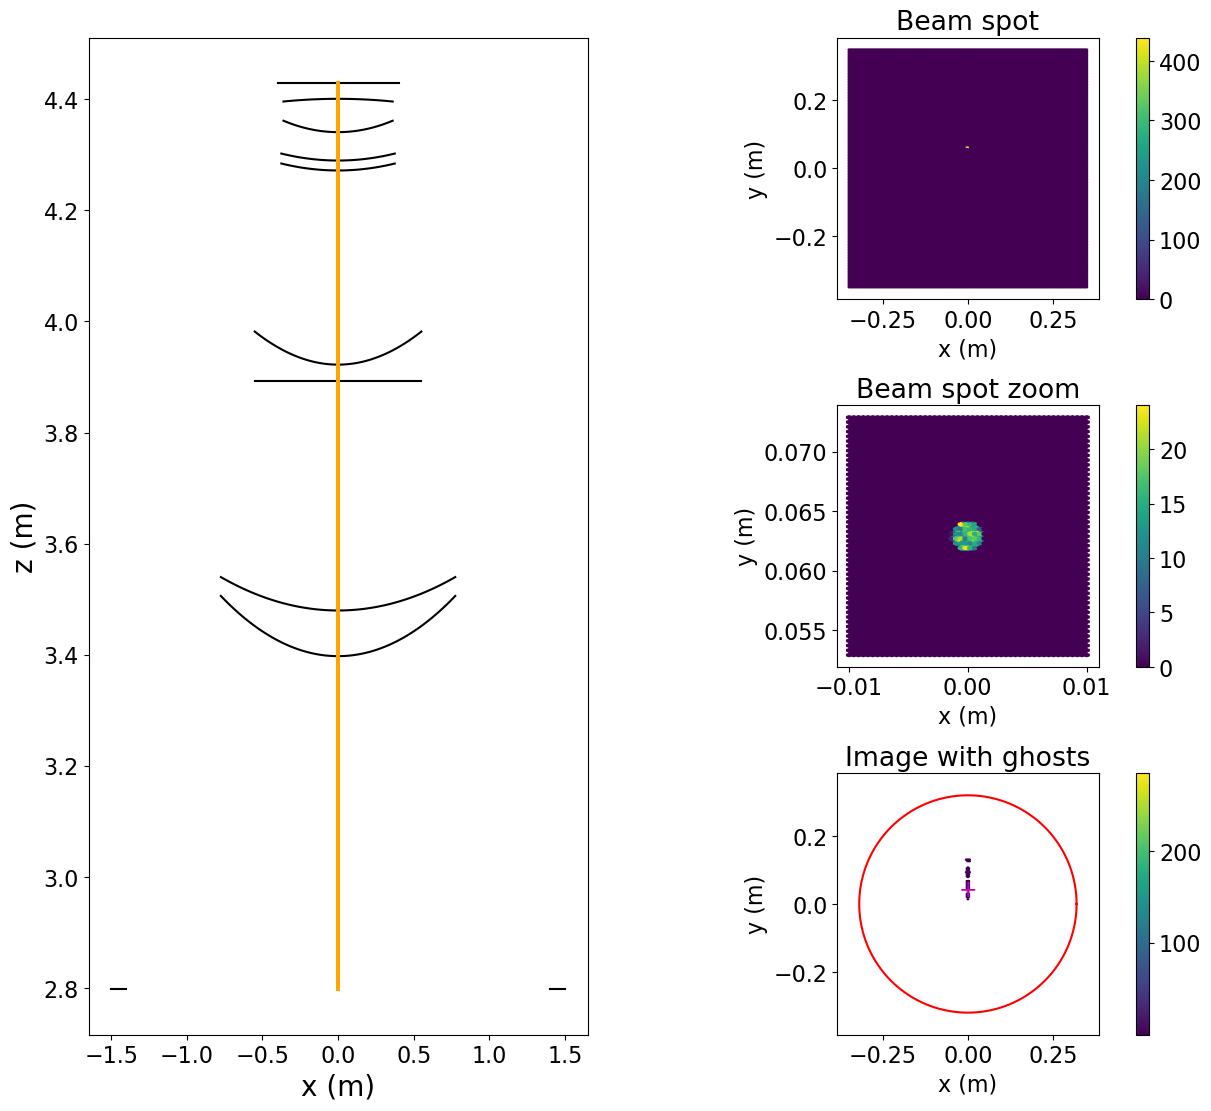

0

In [13]:
# check that with u=large and b=5 the beams rotates around the clock
center = copy.deepcopy(BEAM_CONFIG_0)
test_beam = config_from_angles(center, u=540, b=5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)